In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.calibration import calibration_curve
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
# import adam
from tensorflow.keras.optimizers import Adam


In [9]:

# Define utility functions for evaluation
def plot_calibration(prob_df):
    true_prob, pred_prob = calibration_curve(prob_df['Target'], prob_df['Home_Prob'], n_bins=10)
    plt.figure(figsize=(8, 5))
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
    plt.plot(pred_prob, true_prob, marker='.', label='Model Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Probability')
    plt.title('Calibration Curve')
    plt.legend()
    plt.grid()
    plt.show()

def plot_roc_curve(prob_df):
    fpr, tpr, _ = roc_curve(prob_df['Target'], prob_df['Home_Prob'])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


In [15]:

def build_and_train_model(X_train, y_train, input_dim, log_dir="logs", model_save_path="model_best.keras", epochs=100, batch_size=32):
    """
    Builds and trains a neural network model.
    """
    # Normalize data
    x_train = tf.keras.utils.normalize(X_train, axis=1)
    y_train = np.asarray(y_train)

    # Define callbacks
    tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_loss', mode='min')

    # Build the model
    model = Sequential([
        Flatten(input_shape=(x_train.shape[1],)),
        Dense(512, activation=tf.nn.relu6),
        Dropout(0.3),
        Dense(256, activation=tf.nn.relu6),
        Dropout(0.3),
        Dense(128, activation=tf.nn.relu6),
        Dense(2, activation=tf.nn.softmax)
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.00001), 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])

    # Train the model
    history = model.fit(
        x_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[tensorboard, early_stopping, model_checkpoint],
        verbose=1
    )

    return model, history



In [16]:
# Load and preprocess the data
data = pd.read_parquet('data/processed_dataset.parquet')
meta_cols = ['Season', 'Date', 'Date.1', 'OU-Cover', 'OU', 'Target', 'TEAM_NAME', 'TEAM_NAME.1', 'index']
predictors = [col for col in data.columns if col not in meta_cols]

scaler = StandardScaler()
X = scaler.fit_transform(data[predictors])
y = data['Target'].values

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train the model
model, history = build_and_train_model(X_train, y_train, input_dim=X_train.shape[1])



Epoch 1/100


/Users/adrian/miniforge3/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


303/303 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5616 - loss: 0.6876 - val_accuracy: 0.5779 - val_loss: 0.6746
Epoch 2/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5769 - loss: 0.6747 - val_accuracy: 0.5796 - val_loss: 0.6623
Epoch 3/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5798 - loss: 0.6641 - val_accuracy: 0.5924 - val_loss: 0.6523
Epoch 4/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6021 - loss: 0.6507 - val_accuracy: 0.6238 - val_loss: 0.6440
Epoch 5/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6218 - loss: 0.6443 - val_accuracy: 0.6416 - val_loss: 0.6371
Epoch 6/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6292 - loss: 0.6416 - val_accuracy: 0.6536 - val_loss: 0.6322
Epoch 7/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6492 - loss: 0.6332 - val_accuracy: 0.6569 - val_loss: 0.6289
Epoch 8/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6535 - loss: 0.6278 - val_accuracy: 0.6577

In [17]:
# Evaluate the model
x_test = tf.keras.utils.normalize(X_test, axis=1)
y_pred_prob = model.predict(x_test)[:, 1]  # Get probability of the positive class
y_pred_class = (y_pred_prob >= 0.5).astype(int)

# Create a results DataFrame
results_df = pd.DataFrame({
    'Home_Prob': y_pred_prob,
    'Home_Prob_Neg': 1 - y_pred_prob,
    'Predicted': y_pred_class,
    'Target': y_test
})

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")



95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step
Test Accuracy: 0.6556
Test F1 Score: 0.7149
Test ROC AUC: 0.7044


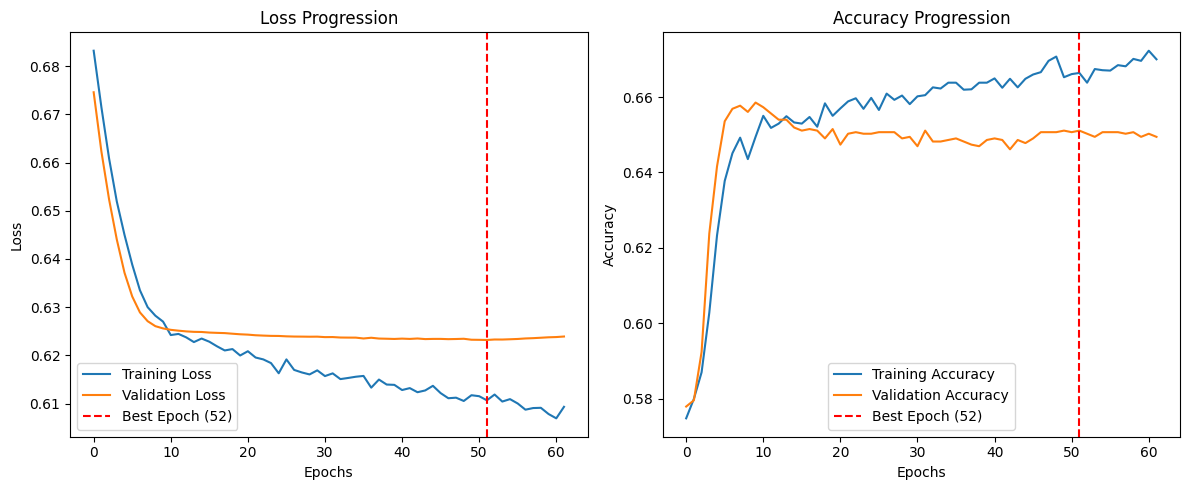

In [18]:
# Find the best epoch
best_epoch = history.history['val_loss'].index(min(history.history['val_loss'])) + 1  # Add 1 because epochs are 1-indexed

# Plot loss and accuracy with best epoch
plt.figure(figsize=(12, 5))

# Loss progression
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axvline(x=best_epoch - 1, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')  # Mark the best epoch
plt.title('Loss Progression')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy progression
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=best_epoch - 1, color='r', linestyle='--', label=f'Best Epoch ({best_epoch})')  # Mark the best epoch
plt.title('Accuracy Progression')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


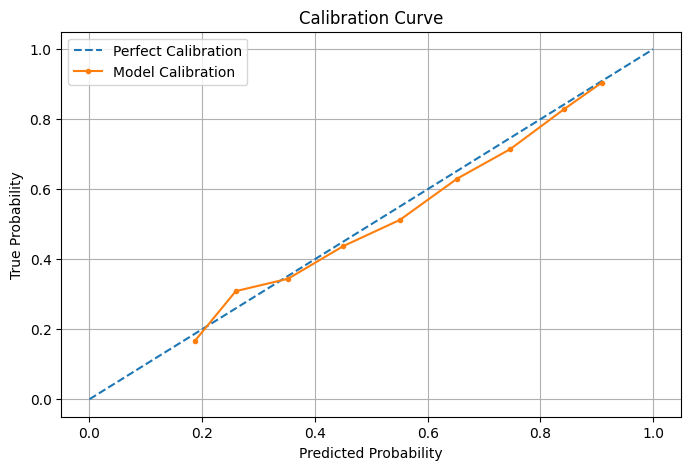

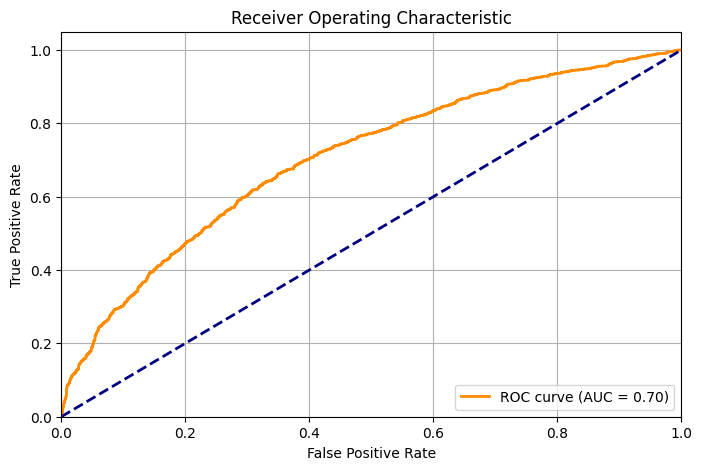

In [19]:
# Plot calibration and ROC curves
plot_calibration(results_df)
plot_roc_curve(results_df)

